In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [2]:
import dill

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="ticks")
sns.set_theme()

In [3]:
base_path = "/home/bryanpu1/projects/aaai_2026/scaling_jax/results"

algo_name = "bandit_ad"
run_name = "adamw-06-09-25_10_17_25-dd55f7aa-c8f9-49f9-b58c-a8af9d8e6d69"

# algo_name = "bandit_dpt"
# run_name = "adamw-06-09-25_10_12_16-0accc7c0-d4f9-42ae-b70e-8b3c590d90e1"

In [4]:
data = dill.load(open(f"{base_path}/{algo_name}/{run_name}/eval_info.dill", "rb"))

In [5]:
data.keys()

dict_keys(['episode_lengths', 'episode_returns', 'action_counts', 'logits', 'eval_config', 'env_params'])

In [6]:
switch_freq = data["eval_config"]["switch_freq"]

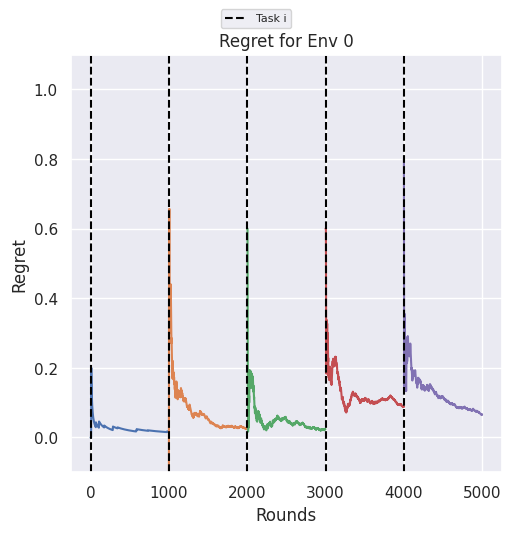

In [7]:
if algo_name.startswith("xland"):
    for k, v in data.items():
        plt.figure()
        plt.plot(range(len(v)), v, label=k)
        plt.title(f"Distribution of returns for {k}")
        plt.xlabel("Episode")
        plt.ylabel("Return")
        plt.show()
elif algo_name.startswith("bandit"):
    (num_envs, num_eps) = data["episode_lengths"].shape
    xrange = range(num_eps)

    num_cols = 1
    num_rows = int(np.ceil(num_envs / 5))

    fig, axes = plt.subplots(
        num_rows,
        num_cols,
        figsize=(5 * num_cols, 5 * num_rows),
        layout="constrained",
    )

    try:
        axes = axes.flatten()
    except:
        axes = [axes]

    for env_i in range(num_envs):
        axes[env_i].set_title(f"Regret for Env {env_i}")
        axes[env_i].set_xlabel("Rounds")
        axes[env_i].set_ylabel("Regret")

        for task_i in range(int(np.ceil(num_eps / switch_freq))):
            rews = np.cumsum(
                data["episode_returns"][env_i, task_i * switch_freq:(task_i + 1) * switch_freq],
                axis=-1,
            )
            xrange = np.arange(min(switch_freq, len(rews)))
            opt = np.max(data["env_params"][env_i, task_i], axis=-1)
            regret = opt - rews / (xrange + 1)
            axes[env_i].plot(task_i * switch_freq + xrange, regret)

            axes[env_i].axvline(
                x=task_i * switch_freq,
                label=f"Task i" if task_i == 0 and env_i == 0 else "",
                linestyle="--",
                color="black"
            )
        axes[env_i].set_ylim(-0.1, 1.1)

    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=5,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )
    fig.show()

In [8]:
print(data["action_counts"])

[[3292. 1557.   48.   57.   46.]]


In [9]:
print(np.argmax(data["env_params"], axis=-1))

[[0 0 0 1 1]]


In [10]:
data["env_params"]

array([[[1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.8       , 0.2       , 0.        , 0.        , 0.        ],
        [0.6       , 0.4       , 0.        , 0.        , 0.        ],
        [0.39999998, 0.6       , 0.        , 0.        , 0.        ],
        [0.19999999, 0.8       , 0.        , 0.        , 0.        ]]],
      dtype=float32)

## Check policy stochasticity

In [11]:
import optax
import jax

In [12]:
action_probs = jax.nn.softmax(data["logits"])
entropies = optax.safe_softmax_cross_entropy(data["logits"], action_probs)

In [13]:
np.max(entropies), np.min(entropies)

(Array(1.6093227, dtype=float32), Array(0.00056552, dtype=float32))

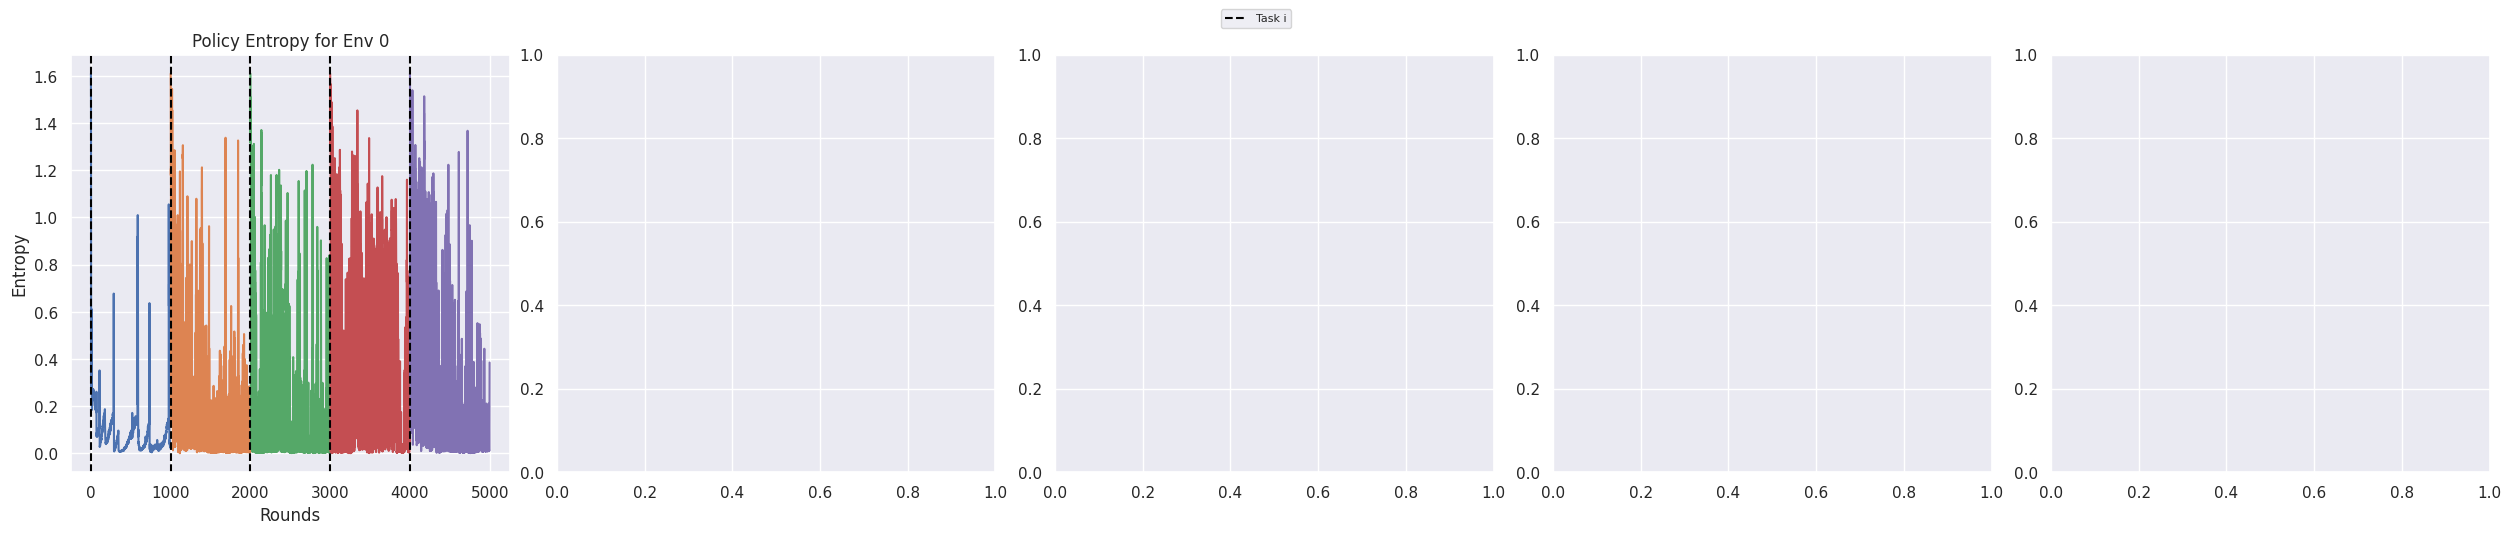

In [14]:
(num_envs, num_eps) = data["episode_lengths"].shape
xrange = range(num_eps)

num_cols = 5
num_rows = int(np.ceil(num_envs / 5))

fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=(5 * num_cols, 5 * num_rows),
    layout="constrained",
)

axes = axes.flatten()

for env_i in range(num_envs):
    axes[env_i].set_title(f"Policy Entropy for Env {env_i}")
    axes[env_i].set_xlabel("Rounds")
    axes[env_i].set_ylabel("Entropy")

    for task_i in range(int(np.ceil(num_eps / switch_freq))):
        entropy = entropies[env_i, task_i * switch_freq:(task_i + 1) * switch_freq]
        xrange = np.arange(min(switch_freq, len(entropy)))
        axes[env_i].plot(task_i * switch_freq + xrange, entropy)

        axes[env_i].axvline(
            x=task_i * switch_freq,
            label=f"Task i" if task_i == 0 and env_i == 0 else "",
            linestyle="--",
            color="black"
        )

fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=5,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.show()

In [15]:
data["env_params"]

array([[[1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.8       , 0.2       , 0.        , 0.        , 0.        ],
        [0.6       , 0.4       , 0.        , 0.        , 0.        ],
        [0.39999998, 0.6       , 0.        , 0.        , 0.        ],
        [0.19999999, 0.8       , 0.        , 0.        , 0.        ]]],
      dtype=float32)